## Projeto 2: Classificando acidentes com e sem vítimas

Para esse projeto, com o intuito de ter mais dados para o treinamento dos modelos, foi necessário adicionar bases dos anos de 2017 à 2019 ao conjunto do ano de 2020 que foi utilizado no projeto 1. Dessa forma, o notebook inicia carregando a base com os dados dos 4 anos agrupados e processados pelo código do projeto 1

In [315]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [316]:
main_df = pd.read_csv('acidentes_group.csv', index_col=0)

Ao comparar a distruibuição dos valores nas colunas 'tipo' e 'natureza_acidente' percebe-se que a base está bastante desbalanceada, além disso a coluna tipo possui 8 valores possíveis e está mais desbalanceada do que 'natureza_acidente' que possui apensa 3 possíveis valores. Dessa forma, escolhi 'natureza_acidente' como a coluna a ser predita.

In [317]:
main_df['tipo'].value_counts()

COLISÃO              27473
ABALROAMENTO          8224
CHOQUE                1485
ATROPELAMENTO          918
ENGAVETAMENTO          397
ACID. DE PERCURSO      149
TOMBAMENTO              98
CAPOTAMENTO             82
Name: tipo, dtype: int64

In [318]:
main_df['natureza_acidente'].value_counts()

SEM VÍTIMA      30552
COM VÍTIMA       8167
VÍTIMA FATAL      107
Name: natureza_acidente, dtype: int64

#### Usando OneHot Encoding para converter os dados categóricos

In [319]:
main_df['bairro'] = main_df['bairro'].astype('category')
main_df['bairro'] = main_df['bairro'].cat.codes
main_df['tipo'] = main_df['tipo'].astype('category')
main_df['tipo'] = main_df['tipo'].cat.codes
main_df['natureza_acidente'] = main_df['natureza_acidente'].astype('category')

In [320]:
dfDummies = pd.get_dummies(main_df['bairro'], prefix = 'bairro')
main_df = pd.concat([main_df, dfDummies], axis=1)
dfDummies2 = pd.get_dummies(main_df['tipo'], prefix = 'tipo')
main_df = pd.concat([main_df, dfDummies2], axis=1)

In [321]:
main_df.isna().sum()

natureza_acidente    0
bairro               0
tipo                 0
auto                 0
moto                 0
                    ..
tipo_3               0
tipo_4               0
tipo_5               0
tipo_6               0
tipo_7               0
Length: 116, dtype: int64

In [322]:
# Embaralhando linhas do dataset
main_df = main_df.sample(frac=1)

### Dividindo dataset em treino, teste e validação

In [323]:
X_acidentes = main_df.drop('natureza_acidente', axis=1)
y_acidentes = main_df['natureza_acidente']

Xtrain, Xtest, ytrain, ytest = train_test_split(X_acidentes, y_acidentes, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Predições
   Nas predições os modelos que utilizei foram: KNN, Árvore de Decisão, Random Forest e Gradient Boosting. 
   
   - Na seleção de hyperparamêtros para o KNN segui o exemplo usado em aula (iteração em uma lista de valores para k usando cross validation para encontrar o melhor valor do número de vizinhos). 
   - Nos demais modelos, utilizei RandomizedSearch com cross validation, o desejo era utilizar GridSearch para ter mais chances de encontrar um melhor global mas, por questões de limitação de hardware e tempo, não foi possível uma vez que o método é mais custoso. Para tentar diminuir um pouco a probabilidade de encontrar apenas um melhores locais, executei o RandomizedSearch uma vez para cada parâmetro

### KNN

In [324]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#### Selecionando hyperparâmetro para o número de vizinhos sobre o conjunto de validação

In [325]:
k_range = range(1, 25)

k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_val, y_val, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8221506761107534, 0.8073406310367032, 0.8341274951706374, 0.836316806181584, 0.8365743721828718, 0.837990985189955, 0.8351577591757888, 0.8339987121699937, 0.8315518351577591, 0.8312942691564713, 0.8302640051513199, 0.8311654861558274, 0.8248551191242756, 0.8256278171281389, 0.8226658081133291, 0.8240824211204121, 0.820991629104958, 0.8209916291049583, 0.8197037990985189, 0.8202189311010946, 0.8169993560849969, 0.8171281390856407, 0.8150676110753381, 0.8168705730843528]


Text(0, 0.5, 'Cross-Validated Accuracy')

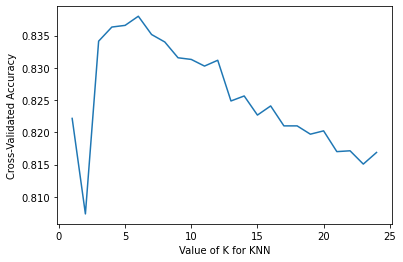

In [326]:
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#### Treinando o modelo com o valor encontrado para K e realizando predição

In [351]:
model = KNeighborsClassifier(n_neighbors=6)

In [354]:
#desempenho no treinamento e teste
y_pred_train = model.fit(Xtrain, ytrain).predict(Xtrain)
y_pred = model.fit(Xtrain, ytrain).predict(Xtest)
accuracy_score(ytrain, y_pred_train), accuracy_score(ytest, y_pred)

(0.8672247263361237, 0.8507597218645377)

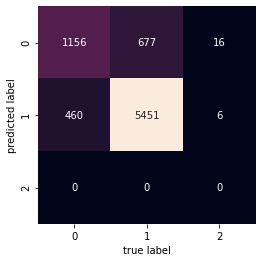

In [355]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, y2_model)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Decision Tree

In [330]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

#### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [331]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(),
                              param_distributions = {'criterion':['gini', 'entropy']},cv = 5, n_iter=2)

random_search_cv.fit(X_val,y_val)

best_criterion = random_search_cv.best_params_['criterion']
#Vamos ver informações relevantes:
print('Melhor criterion: {}'.format(best_criterion))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor criterion: entropy
Desempenho do melhor modelo: 0.848


In [332]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion=random_search_cv.best_params_['criterion']),
                              param_distributions = {'splitter':['best', 'random']},cv = 5, n_iter=2)

random_search_cv.fit(X_val,y_val)

best_splitter = random_search_cv.best_params_['splitter']
#Vamos ver informações relevantes:
print('Melhor splitter: {}'.format(best_splitter))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor splitter: random
Desempenho do melhor modelo: 0.848


In [333]:
random_search_cv = RandomizedSearchCV(estimator = DecisionTreeClassifier(criterion= best_criterion, 
                                                                         splitter=best_splitter),
                              param_distributions = {'max_depth': [5, 8, 15, 25, 30]},cv = 5, n_iter=5)

random_search_cv.fit(X_val,y_val)

tree_max_depth = random_search_cv.best_params_['max_depth']
#Vamos ver informações relevantes:
print('Melhor max_depth: {}'.format(tree_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor max_depth: 8
Desempenho do melhor modelo: 0.859


#### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [334]:
clf_tree = DecisionTreeClassifier(criterion=best_criterion, splitter=best_splitter, max_depth=tree_max_depth)

In [335]:
clf_tree.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=8, splitter='random')

In [336]:
tree_pred = clf_tree.predict(Xtest)
tree_pred_train = clf_tree.predict(Xtrain)

In [337]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, tree_pred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, tree_pred)))

ACC TRAINING:0.8686091435930458
ACC TEST:0.8645377285603915


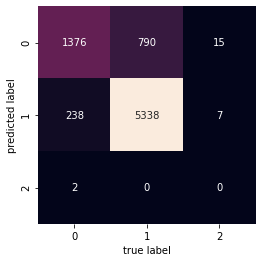

In [338]:
mat = confusion_matrix(ytest, tree_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Random Forest

In [339]:
from sklearn.ensemble import RandomForestClassifier

#### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [340]:
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(),
                              param_distributions = {'n_estimators':range(1,1000,100)},cv = 5,n_iter = 10)

random_search_cv.fit(X_val,y_val)

rf_estimators = random_search_cv.best_params_['n_estimators']

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(rf_estimators))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor número de estimadores: 801
Desempenho do melhor modelo: 0.857


In [341]:
random_search_cv = RandomizedSearchCV(estimator = RandomForestClassifier(n_estimators = rf_estimators),
                              param_distributions = {'max_depth': [5, 8, 15, 25, 30]},cv = 5, n_iter = 5)

random_search_cv.fit(X_val,y_val)

rf_max_depth = random_search_cv.best_params_['max_depth']

#Vamos ver informações relevantes:
print('Melhor max_depth: {}'.format(rf_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor max_depth: 15
Desempenho do melhor modelo: 0.859


#### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [342]:
model = RandomForestClassifier(n_estimators=rf_estimators, max_depth=rf_max_depth)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

In [343]:
print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))

ACC TRAINING:0.8768190598840953
ACC TEST:0.8629925315477723


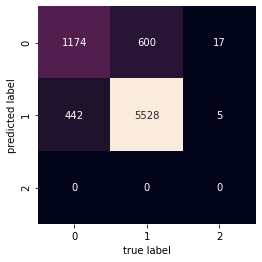

In [344]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Gradient Boosting

In [345]:
from sklearn.ensemble import GradientBoostingClassifier

#### Selecionando hyperparâmetros sobre o conjunto de validação com RandomizedSearch

In [346]:
from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(),
                              param_distributions = {'n_estimators':range(10,100,5)},cv = 3,n_iter = 10)

random_search_cv.fit(X_val,y_val)

gb_estimators = random_search_cv.best_params_['n_estimators']

#Vamos ver informações relevantes:
print('Melhor número de estimadores: {}'.format(gb_estimators))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Melhor número de estimadores: 30
Desempenho do melhor modelo: 0.862


In [347]:
random_search_cv = RandomizedSearchCV(estimator = GradientBoostingClassifier(n_estimators=gb_estimators),
                            param_distributions = {'max_depth':range(5,16,2)},
                            cv = 3,n_iter = 6)

random_search_cv.fit(X_val,y_val)

gb_max_depth = random_search_cv.best_params_['max_depth']
#Vamos ver informações relevantes:
print('Max depth: {}'.format(gb_max_depth))
print('Desempenho do melhor modelo: {}'.format(round(random_search_cv.best_score_,3)))

Max depth: 5
Desempenho do melhor modelo: 0.858


#### Treinando o modelo com os valores encontrados para os hyperparâmetros e realizando predição

In [348]:
modelGB = GradientBoostingClassifier(n_estimators=gb_estimators, max_depth=gb_max_depth)
modelGB.fit(Xtrain, ytrain)

GradientBoostingClassifier(max_depth=5, n_estimators=30)

In [349]:
ypred = modelGB.predict(Xtest)
ypred_train = modelGB.predict(Xtrain)
print("ACC TRAINING:" + str(accuracy_score(ytrain, ypred_train)))
print("ACC TEST:" + str(accuracy_score(ytest, ypred)))

ACC TRAINING:0.8718931101094656
ACC TEST:0.862348699459181


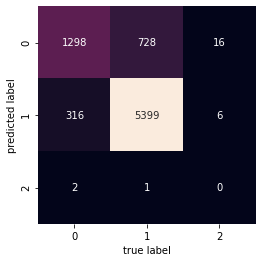

In [350]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');